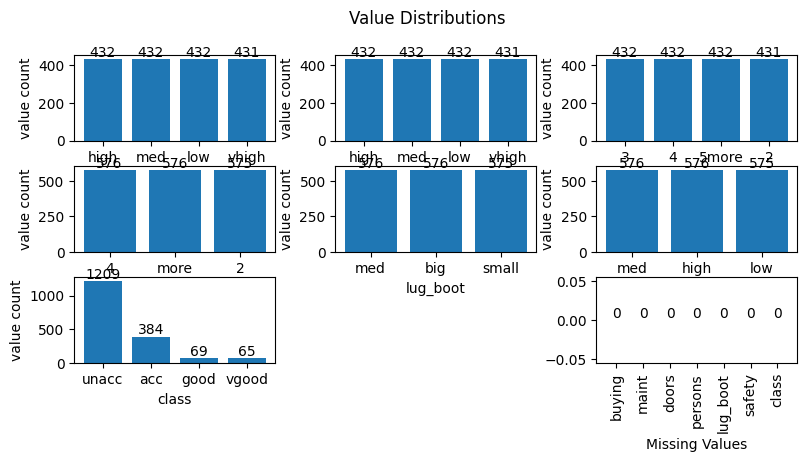

In [63]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from category_encoders import OrdinalEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn import tree
import graphviz 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import sys
import os

%matplotlib inline
helper_path = os.path.abspath('/kaggle/titanic')
if helper_path not in sys.path:
    sys.path.append(helper_path)
import helper as hp

df= pd.read_csv("/kaggle/car_evaluation/car_evaluation.csv")

# rename columns appropriately
col_names = ['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety', 'class']
df.columns = col_names
X = df.drop('class', axis=1)
y = df['class']

#  Set up plot
fig, ax = plt.subplots(3, 3, figsize=(8,4))
ax = ax.flatten()
fig.suptitle("Value Distributions")
fig.tight_layout()
plt.subplots_adjust(hspace=0.3, wspace=0.3)

# show distribution of values in each column.
for i, col in enumerate(col_names):
    vc = df[col].value_counts()
    bars = ax[i].bar(vc.keys(), vc.values)
    ax[i].set_xlabel(col)
    ax[i].set_ylabel("value count")
    hp.show_values_on_bar(bars, ax[i])


# hide unused plot
for j in range(len(col_names), len(ax)-1):
    fig.delaxes(ax[j])

# Missing Data
missing = df.isna().sum()
j = len(ax) - 1
bars = ax[j].bar(missing.keys(), missing.values, color='r')
ax[j].set_xlabel("Missing Values")
ax[j].set_xticks(range(len(col_names)))
ax[j].set_xticklabels(col_names, rotation=90)
hp.show_values_on_bar(bars, ax[j])

None

In [57]:
# Split data and transform to ordinals.
X_train, X_test, y_train, y_test = train_test_split(X, y)


# transform to ordinals:
ordinal_mapping = [
    {'col': 'buying', 'mapping':   {'low': 1,   'med': 2, 'high': 3, 'vhigh': 4}},
    {'col': 'maint', 'mapping':    {'low': 1,   'med': 2, 'high': 3, 'vhigh': 4}},
    {'col': 'doors', 'mapping':    {'2': 1,     '3': 2,   '4': 3,    '5more': 4}},
    {'col': 'persons', 'mapping':  {'2': 1,     '4': 2,   'more': 3}},
    {'col': 'lug_boot', 'mapping': {'small': 1, 'med': 2, 'big': 3}},
    {'col': 'safety', 'mapping':   {'low': 1,   'med': 2, 'high': 3}}
]

oe = OrdinalEncoder(mapping=ordinal_mapping)
X_train = oe.fit_transform(X_train)
X_test = oe.transform(X_test)


In [58]:
# make decision tree models, and fit them

# Create list of gini models with different max_depths
gini_models = []
for depth in range(2, 10):
    model = DecisionTreeClassifier(criterion='gini', max_depth=depth)
    model.fit(X_train, y_train)
    gini_models.append(model)
    # Assign each model to a variable named giniN where N is the depth
    globals()[f'gini{depth}'] = model

# Generate predictions for each model in gini_models
for model in gini_models:
    depth = model.get_params()['max_depth']
    y_pred_train = model.predict(X_train)
    train_accuracy = accuracy_score(y_train, y_pred_train)
    y_pred = model.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_pred)
    print(f'Depth {depth} accuracy - Train: {train_accuracy:.4f}, Test: {test_accuracy:.4f}')


Depth 2 accuracy - Train: 0.7722, Test: 0.7940
Depth 3 accuracy - Train: 0.7931, Test: 0.7870
Depth 4 accuracy - Train: 0.8517, Test: 0.8472
Depth 5 accuracy - Train: 0.8680, Test: 0.8819
Depth 6 accuracy - Train: 0.9313, Test: 0.9444
Depth 7 accuracy - Train: 0.9375, Test: 0.9468
Depth 8 accuracy - Train: 0.9761, Test: 0.9722
Depth 9 accuracy - Train: 0.9846, Test: 0.9792


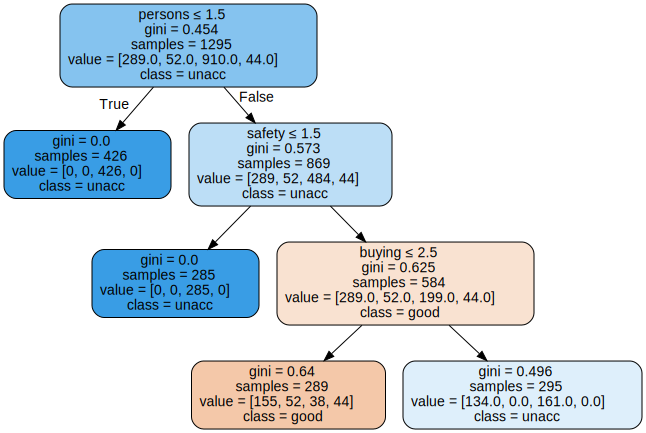

In [59]:
# better with graphviz
dot_data = tree.export_graphviz(gini3, out_file=None, 
                              feature_names=X_train.columns,  
                              class_names=y_train,  
                              filled=True, rounded=True,  
                              special_characters=True)

graph = graphviz.Source(dot_data) 

graph 

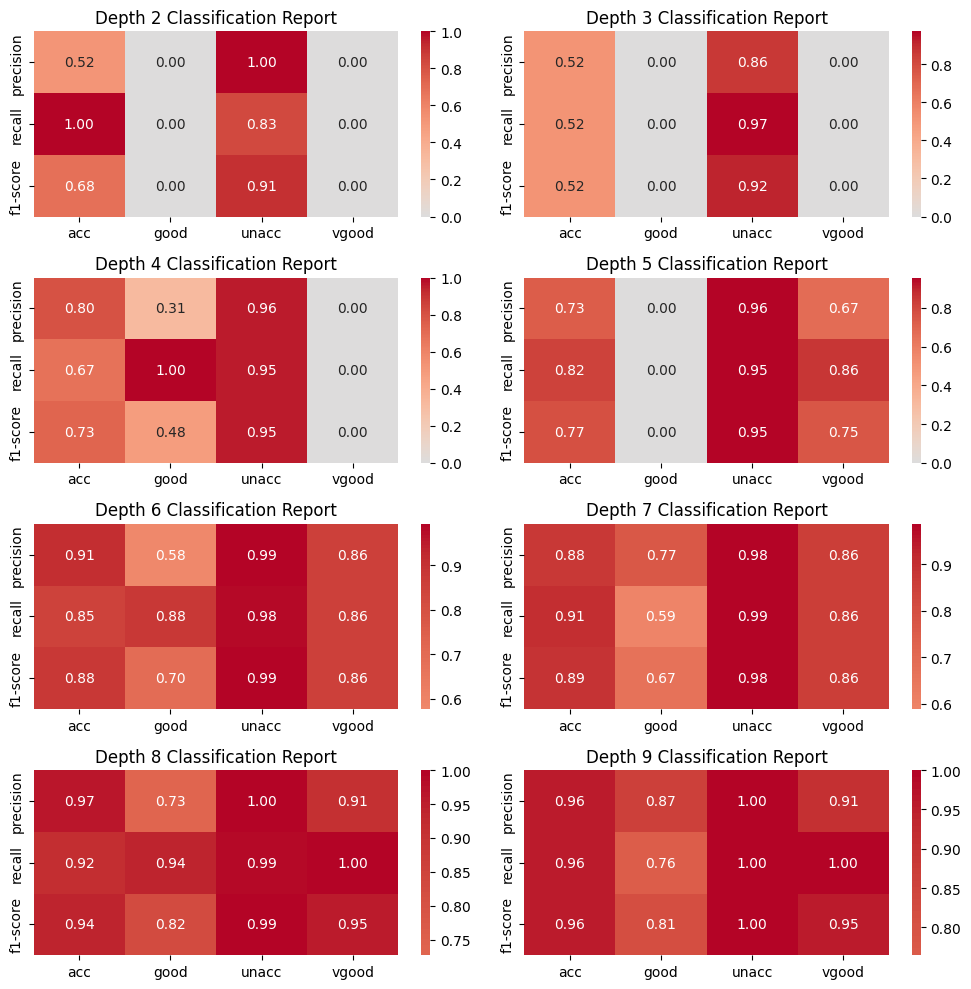

In [60]:
# Create subplots for all gini models
fig, axes = plt.subplots(4, 2, figsize=(10, 10))
axes = axes.ravel()

for i, model in enumerate(gini_models):
    # Get predictions
    y_pred = model.predict(X_test)
    
    # Get classification report
    
    cr = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
    
    # Convert to dataframe for heatmap
    cr_df = pd.DataFrame(cr)
    cr_df = cr_df.drop('support')
    cr_df = cr_df.drop(['accuracy', 'macro avg', 'weighted avg'], axis=1)
    
    # Create heatmap
    sns.heatmap(cr_df, annot=True, cmap='coolwarm', center=0, fmt='.2f', ax=axes[i])
    axes[i].set_title(f'Depth {model.get_params()["max_depth"]} Classification Report')

plt.tight_layout()
plt.show()
